In [1]:
import sqlite3
import pandas as pd

# Create a connection to the SQLite database
conn = sqlite3.connect('/Users/cris/PycharmProjects/DBL 2 - JBG050/police_data.db')

# Create a DataFrame for each table and print the first few rows

stop_and_search_df = pd.read_sql_query("SELECT * from stop_and_search", conn)



# Close the connection
conn.close()


In [2]:
pas = pd.read_excel('/Users/cris/PycharmProjects/DBL 2 - JBG050/PAS.xlsx', sheet_name='Borough')

pas.head()

,Date,Survey,Borough,Measure,Proportion,MPS,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2014-12-31,PAS,Barking and Dagenham,"""Good Job"" local",0.56,0.67,NaN,NaN,NaN,NaN
1,2014-12-31,PAS,Barnet,"""Good Job"" local",0.67,0.67,NaN,NaN,NaN,NaN
2,2014-12-31,PAS,Bexley,"""Good Job"" local",0.72,0.67,NaN,NaN,NaN,NaN
3,2014-12-31,PAS,Brent,"""Good Job"" local",0.66,0.67,NaN,NaN,NaN,NaN
4,2014-12-31,PAS,Bromley,"""Good Job"" local",0.71,0.67,NaN,NaN,NaN,NaN


In [3]:
pas = pas.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])
stop_and_search_df = stop_and_search_df[stop_and_search_df['borough'] != 'city of london']
# Drop columns with 100% null values
stop_and_search_df.drop(['policing_operation', 'outcome_linked_to_object_of_search', 'removal_of_more_than_just_outer_clothing'], axis=1, inplace=True)

# Remove rows with null values in the remaining columns
stop_and_search_df.dropna(inplace=True)

In [4]:

# For stop_and_search_df dataframe
stop_and_search_df['month'] = pd.to_datetime(stop_and_search_df['month'])
stop_and_search_df['Year'] = stop_and_search_df['month'].dt.year
stop_and_search_df['Month'] = stop_and_search_df['month'].dt.month
stop_and_search_df = stop_and_search_df.drop('month', axis=1)

# For pas dataframe
pas['Date'] = pd.to_datetime(pas['Date'])
pas['Year'] = pas['Date'].dt.year
pas['Month'] = pas['Date'].dt.month
pas = pas.drop('Date', axis=1)

# Create sets of (Year, Month) tuples for both datasets
pas_periods = set(zip(pas['Year'], pas['Month']))
stop_and_search_periods = set(zip(stop_and_search_df['Year'], stop_and_search_df['Month']))

# Find intersection to get the overlapping periods
overlap_periods = list(pas_periods.intersection(stop_and_search_periods))

# Filter both datasets to include only records from overlapping periods
pas = pas[pas.set_index(['Year', 'Month']).index.isin(overlap_periods)]
stop_and_search_df = stop_and_search_df[stop_and_search_df.set_index(['Year', 'Month']).index.isin(overlap_periods)]




In [5]:
# convert all borough names to a consistent case (all lowercase)
pas.rename(columns={'Borough': 'borough'}, inplace=True)


pas['borough'] = pas['borough'].str.lower()
stop_and_search_df['borough'] = stop_and_search_df['borough'].str.lower()




In [6]:
pas['borough'] = pas['borough'].replace('city of westminster', 'westminster')


In [7]:
combined_data = pd.merge(pas, stop_and_search_df, on=['borough', 'Year', 'Month'], how='inner')


In [8]:
# Drop specified columns
columns_to_drop = ['Survey', 'latitude', 'longitude', 'self_defined_ethnicity','part_of_a_policing_operation','MPS']
combined_data.drop(columns=columns_to_drop, inplace=True)

In [9]:
combined_data.drop(columns='Measure',inplace=True)


This is where the General Preprocessing ends, below will be more specific preprocessing like one hot encoding

In [10]:
# One-hot encode the 'outcome' variable
outcome_dummies = pd.get_dummies(stop_and_search_df['outcome'], prefix='outcome')
stop_and_search_df_encoded = pd.concat([stop_and_search_df.drop('outcome', axis=1), outcome_dummies], axis=1)

# Aggregate these outcomes by counting occurrences of each outcome type per borough-month
outcome_counts = stop_and_search_df_encoded.groupby(['borough', 'Year', 'Month']).sum().reset_index()

# Merge this aggregated data back with the PAS data
combined_agg = pd.merge(pas, outcome_counts, on=['borough', 'Year', 'Month'], how='inner')

In [11]:

# List of relevant object attributes to encode
object_attributes = [
    'borough', 'type', 
    'gender', 'age_range', 'officer_defined_ethnicity',
    'legislation', 'object_of_search'
]

# One-hot encoding of all relevant object attributes
encoded_combined_agg = pd.get_dummies(combined_agg, columns=object_attributes, drop_first=True)


In case we want to separate by Trust and Confidence (Null Values) We have to think about on how we group

In [146]:
# import pandas as pd
# 
# 
# 
# trust_measures = {'Trust MPS', 'Contact ward officer', 'Listen to concerns', 'Treat everyone fairly'}
# confidence_measures = {'Good Job local', 'Understand issues', 'Relied on to be there', 'Informed local'}
# 
# pas['Measure'] = pas['Measure'].str.strip().str.replace('"', '')
# 
# pas['Trust'] = None
# pas['Confidence'] = None
# 
# pas.loc[pas['Measure'].isin(trust_measures), 'Trust'] = pas['Proportion']
# 
# pas.loc[pas['Measure'].isin(confidence_measures), 'Confidence'] = pas['Proportion']
# 
# # Optionally, drop the original column
# # pas = pas.drop(columns=['Proportion'])


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# List of relevant object attributes to encode
object_attributes = [
    'borough', 'type', 'gender', 'age_range', 'officer_defined_ethnicity',
    'legislation', 'object_of_search'
]

# # Feature selection for random forest
# X = combined_data.drop(columns=['Proportion'])
# y = combined_data['Proportion']


# Feature selection for random forest
X = combined_data[[ 'officer_defined_ethnicity','age_range','legislation']]
y = combined_data['Proportion']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['int32', 'float64']).columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['officer_defined_ethnicity','age_range','legislation'])
    ]
)


# # Preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), X.select_dtypes(include=['int32', 'float64']).columns),
#         ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), object_attributes)
#     ]
# )

# Random Forest model with optimized parameters
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred = rf_pipeline.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')




Mean Squared Error: 0.043067705879799724
R^2 Score: 0.0014236853551519157


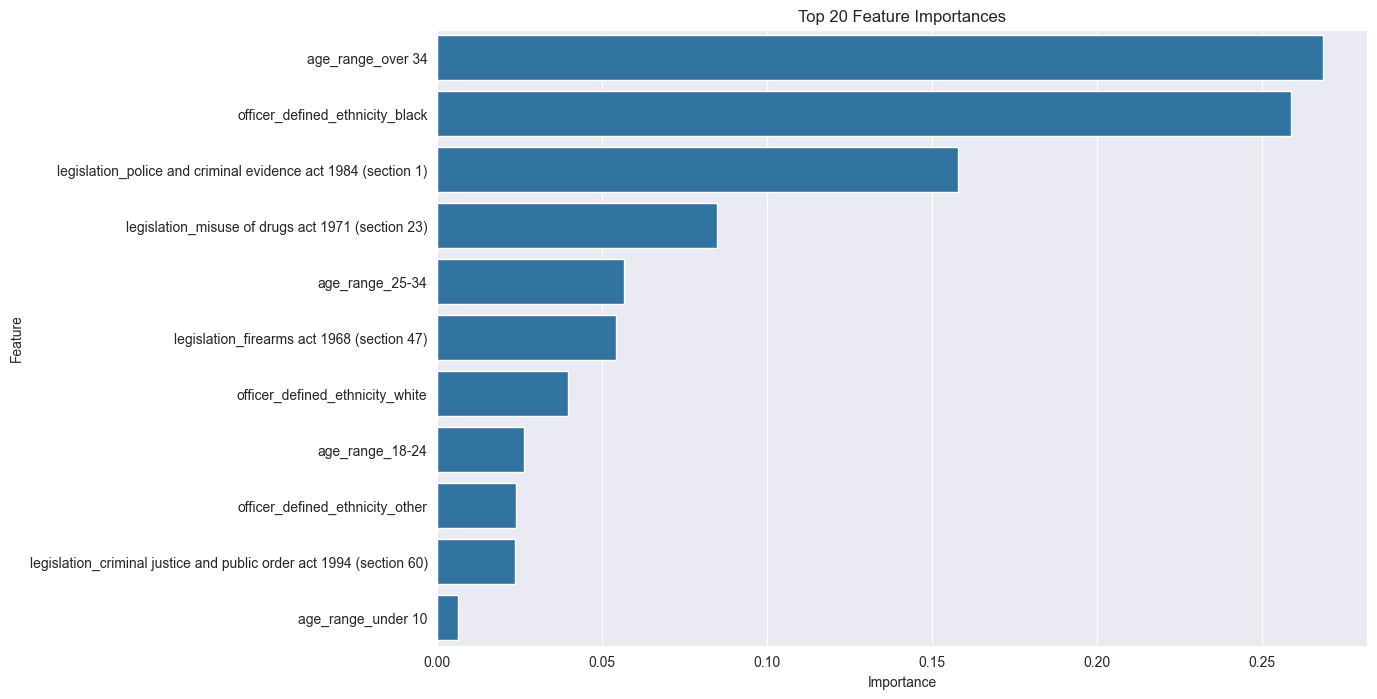

In [13]:
# Extract feature importances
importances = rf_pipeline.named_steps['regressor'].feature_importances_

# Get feature names
num_features = X.select_dtypes(include=['int32', 'float64']).columns.tolist()
cat_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist()
feature_names = num_features + cat_features

# Combine feature names and importances into a DataFrame
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Top 20 Feature Importances')
plt.show()

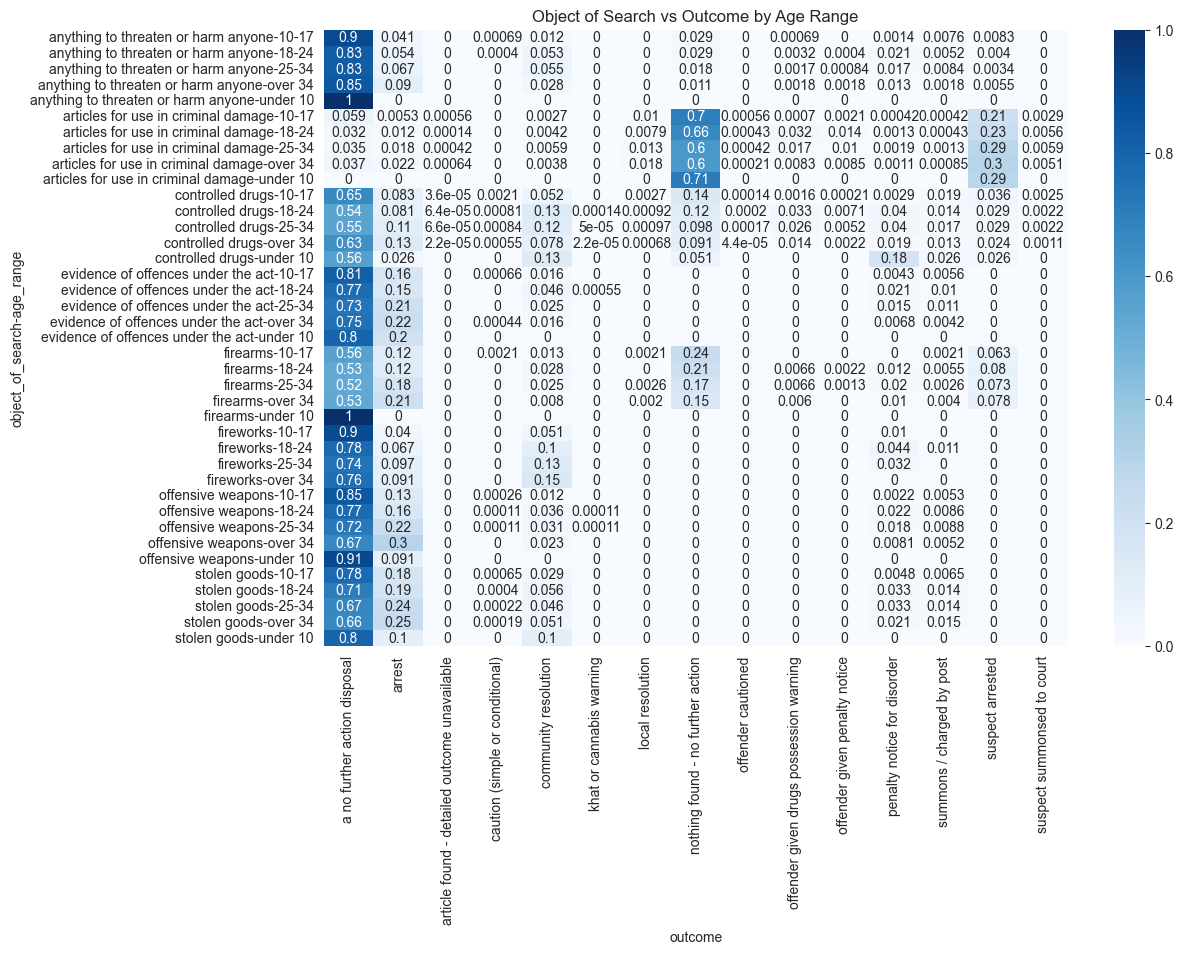

In [177]:

# Relationship analysis
# Cross-tabulation of object of search and outcome by age range and ethnicity

cross_tab = pd.crosstab([stop_and_search_df['object_of_search'], stop_and_search_df['age_range']], stop_and_search_df['outcome'], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, cmap='Blues')
plt.title('Object of Search vs Outcome by Age Range')
plt.show()

## Visualize the: 'Are there differences between the different classified ethnicity's in terms of trust regarding interaction between police and civilians? '


Preprocessing and loading data

Assumption:

The trust score for a borough and month can be influenced by the ethnic composition of stop-and-search incidents in that same period.
We assume that if a borough has a higher proportion of stop-and-search incidents for a particular ethnicity, it could reflect on the trust level for that ethnicity.

In [205]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Load the data
conn = sqlite3.connect('/Users/cris/PycharmProjects/DBL 2 - JBG050/police_data.db')
stop_and_search_df = pd.read_sql_query("SELECT * from stop_and_search", conn)
conn.close()

pas = pd.read_excel('/Users/cris/PycharmProjects/DBL 2 - JBG050/PAS.xlsx', sheet_name='Borough')
pas = pas.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

# Define Function for preprocessing officer defined ethnicity
def group_ethnicity(row):
    ethnicity = row['officer_defined_ethnicity'].lower()
    if 'white' in ethnicity:
        return 'White'
    elif 'black' in ethnicity:
        return 'Black'
    elif 'asian' in ethnicity or 'chinese' in ethnicity:
        return 'Asian'
    elif 'mixed' in ethnicity or 'other' in ethnicity or 'not stated' in ethnicity:
        return 'Mixed/Other'
    else:
        return 'Unknown'

# Data cleaning steps 
stop_and_search_df = stop_and_search_df[stop_and_search_df['borough'] != 'city of london']
stop_and_search_df.drop(['policing_operation', 'outcome_linked_to_object_of_search', 'removal_of_more_than_just_outer_clothing'], axis=1, inplace=True)
stop_and_search_df.dropna(inplace=True)
stop_and_search_df['month'] = pd.to_datetime(stop_and_search_df['month'])
stop_and_search_df['Year'] = stop_and_search_df['month'].dt.year
stop_and_search_df['Month'] = stop_and_search_df['month'].dt.month
stop_and_search_df = stop_and_search_df.drop('month', axis=1)
pas['Date'] = pd.to_datetime(pas['Date'])
pas['Year'] = pas['Date'].dt.year
pas['Month'] = pas['Date'].dt.month
pas = pas.drop('Date', axis=1)
pas_periods = set(zip(pas['Year'], pas['Month']))
stop_and_search_periods = set(zip(stop_and_search_df['Year'], stop_and_search_df['Month']))
overlap_periods = list(pas_periods.intersection(stop_and_search_periods))
pas = pas[pas.set_index(['Year', 'Month']).index.isin(overlap_periods)]
stop_and_search_df = stop_and_search_df[stop_and_search_df.set_index(['Year', 'Month']).index.isin(overlap_periods)]
pas.rename(columns={'Borough': 'borough'}, inplace=True)
pas['borough'] = pas['borough'].str.lower()
stop_and_search_df['borough'] = stop_and_search_df['borough'].str.lower()
pas['borough'] = pas['borough'].replace('city of westminster', 'westminster')

# Apply the group_ethnicity function
stop_and_search_df['grouped_ethnicity'] = stop_and_search_df.apply(group_ethnicity, axis=1)

# Aggregate the stop_and_search data by borough, Year, Month, and ethnicity
ethnicity_agg = stop_and_search_df.groupby(['borough', 'Year', 'Month', 'grouped_ethnicity']).size().unstack(fill_value=0)
ethnicity_agg = ethnicity_agg.reset_index()

# Merge PAS data with the aggregated stop_and_search data
combined_df = pd.merge(pas, ethnicity_agg, on=['borough', 'Year', 'Month'], how='inner')

# Calculate proportion of each ethnicity in total stops for each borough and month
ethnicity_columns = combined_df.columns.difference(['borough', 'Year', 'Month', 'Survey', 'Measure', 'Proportion', 'MPS'])
combined_df['total_stops'] = combined_df[ethnicity_columns].sum(axis=1)
for col in ethnicity_columns:
    combined_df[col + '_prop'] = combined_df[col] / combined_df['total_stops']

# Calculate weighted trust scores for each ethnicity
weighted_trust_scores = {}
for col in ethnicity_columns:
    weighted_trust_scores[col] = (combined_df['Proportion'] * combined_df[col + '_prop']).sum() / combined_df[col + '_prop'].sum()

# ANOVA Test for trust scores across ethnic groups
ethnicity_trust_values = [combined_df[combined_df[col + '_prop'] > 0]['Proportion'] for col in ethnicity_columns]
f_stat, p_value = f_oneway(*ethnicity_trust_values)

# Display the results
print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value:", p_value)


# Display mean trust scores for each ethnicity
print("Weighted mean trust scores for each ethnicity:")
for eth, score in weighted_trust_scores.items():
    print(f"{eth}: {score}")


ANOVA F-statistic: 0.4066512017241132
ANOVA p-value: 0.7482237517971795
Weighted mean trust scores for each ethnicity:
Asian: 0.5947373380505486
Black: 0.5836698200787183
Mixed/Other: 0.5918126083737933
White: 0.5943908286590517


there are no statistically significant differences in trust scores among the different ethnicities 

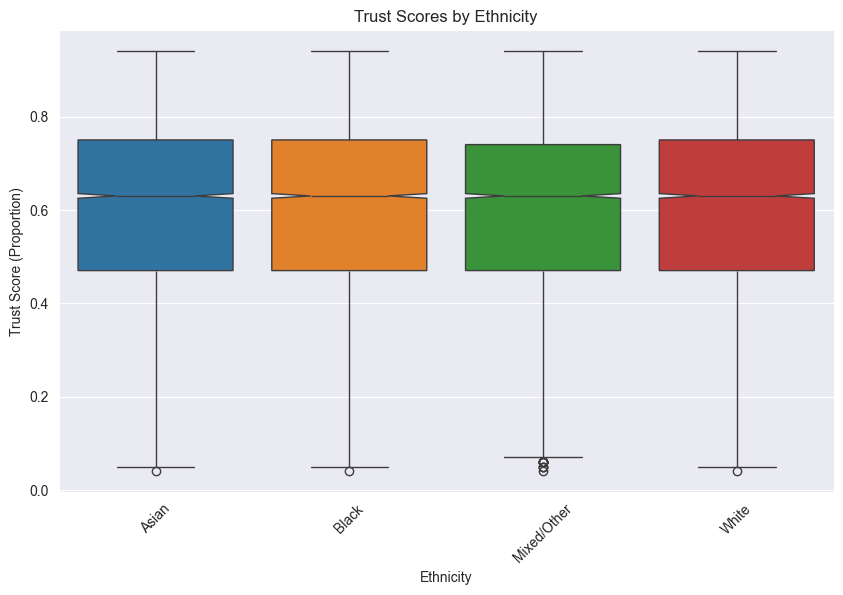

In [209]:
# Prepare the data for visualization
ethnicity_trust_values = {
    'Asian': combined_df[combined_df['Asian_prop'] > 0]['Proportion'],
    'Black': combined_df[combined_df['Black_prop'] > 0]['Proportion'],
    'Mixed/Other': combined_df[combined_df['Mixed/Other_prop'] > 0]['Proportion'],
    'White': combined_df[combined_df['White_prop'] > 0]['Proportion']
}

# Create a DataFrame for plotting
visualization_df = pd.DataFrame.from_dict(ethnicity_trust_values, orient='index').transpose()

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=visualization_df, notch=True)
plt.xticks(ticks=range(len(ethnicity_columns)), labels=ethnicity_trust_values.keys(), rotation=45)
plt.xlabel('Ethnicity')
plt.ylabel('Trust Score (Proportion)')
plt.title('Trust Scores by Ethnicity')
plt.show()


## Relationship Between Object of Search, Outcome, Age Range, and Ethnicity

In [210]:
stop_and_search_df.dtypes

type                             object
part_of_a_policing_operation     object
latitude                        float64
longitude                       float64
gender                           object
age_range                        object
self_defined_ethnicity           object
officer_defined_ethnicity        object
legislation                      object
object_of_search                 object
outcome                          object
borough                          object
Year                              int32
Month                             int32
grouped_ethnicity                object
dtype: object

In [209]:
# When performing a chi-square test and creating contingency tables for categorical variables, it's unnecessary to encode the categorical variables into numerical form. The chi-square test and functions like pd.crosstab() are designed to work directly with categorical data. Thus, it's fine to keep the data as objects (strings) for this analysis.

 Relationship between Ethnicity, and Outcome


In [222]:
ethnicity_outcome_ct

outcome,a no further action disposal,arrest,article found - detailed outcome unavailable,caution (simple or conditional),community resolution,khat or cannabis warning,local resolution,nothing found - no further action,offender cautioned,offender given drugs possession warning,offender given penalty notice,penalty notice for disorder,summons / charged by post,suspect arrested,suspect summonsed to court
grouped_ethnicity,,,,,,,,,,,,,,,
Asian,0.615341,0.096835,0.000064,0.000691,0.084434,0.000064,0.000932,0.100177,0.000177,0.017157,0.005317,0.036257,0.015116,0.025622,0.001815
Black,0.584638,0.128971,0.000058,0.000464,0.067340,0.000051,0.001400,0.121207,0.000087,0.013162,0.003475,0.023334,0.012444,0.041503,0.001865
Mixed/Other,0.626255,0.120932,0.000000,0.000122,0.083095,0.000000,0.001156,0.085528,0.000000,0.014904,0.002251,0.024697,0.014052,0.025671,0.001338
White,0.596736,0.121734,0.000067,0.000867,0.083123,0.000073,0.001734,0.109615,0.000147,0.017461,0.002915,0.020909,0.010425,0.032995,0.001201


Chi-squared Test: chi2 = 0.03114474060919667, p-value = 1.0


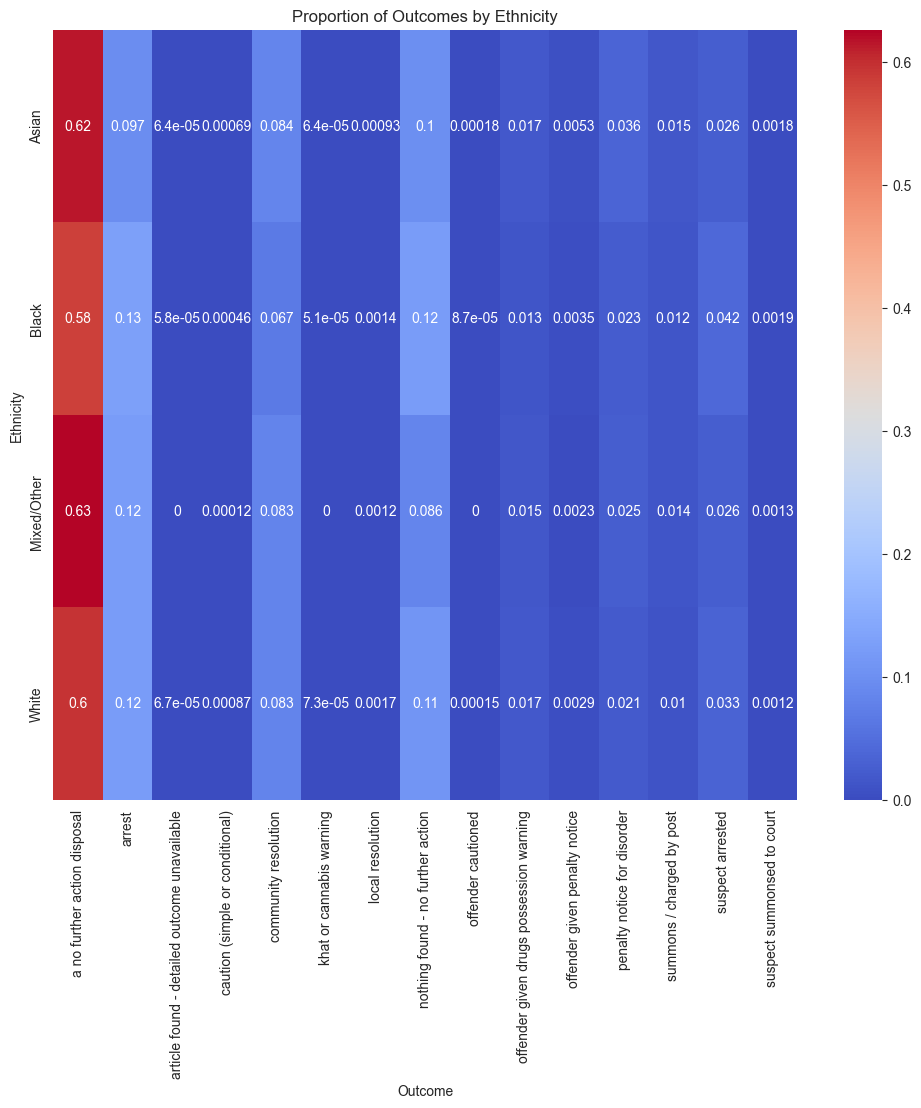

In [221]:
from scipy.stats import chi2_contingency

# Calculate proportions for ethnicity and outcome
ethnicity_outcome_ct = pd.crosstab(stop_and_search_df['grouped_ethnicity'], stop_and_search_df['outcome'], normalize='index')
chi2, p, dof, ex = chi2_contingency(ethnicity_outcome_ct)
print(f"Chi-squared Test: chi2 = {chi2}, p-value = {p}")

# Visualize the relationship
plt.figure(figsize=(12, 10))
sns.heatmap(ethnicity_outcome_ct, annot=True, cmap='coolwarm')
plt.title('Proportion of Outcomes by Ethnicity')
plt.xlabel('Outcome')
plt.ylabel('Ethnicity')
plt.show()


Ethnicity and Object of Search

object_of_search   anything to threaten or harm anyone  \
grouped_ethnicity                                        
Asian                                         0.017157   
Black                                         0.019569   
Mixed/Other                                   0.019770   
White                                         0.010718   

object_of_search   articles for use in criminal damage  controlled drugs  \
grouped_ethnicity                                                          
Asian                                         0.036402          0.731582   
Black                                         0.070199          0.584312   
Mixed/Other                                   0.047570          0.621023   
White                                         0.072278          0.605787   

object_of_search   evidence of offences under the act  firearms  fireworks  \
grouped_ethnicity                                                            
Asian                                 

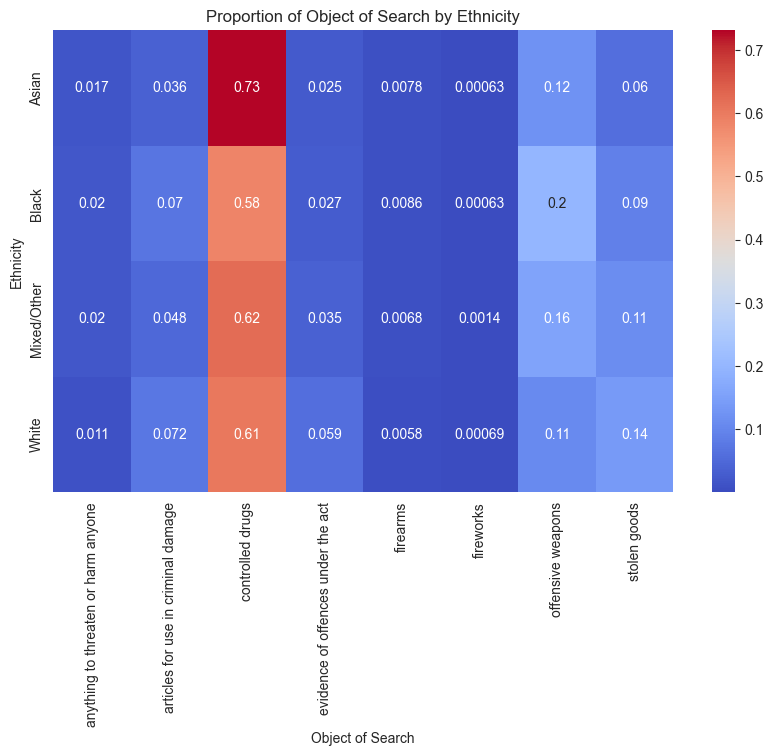

In [223]:
# Calculate proportions for ethnicity and object of search
ethnicity_object_ct = pd.crosstab(stop_and_search_df['grouped_ethnicity'], stop_and_search_df['object_of_search'], normalize='index')
print(ethnicity_object_ct)
chi2, p, dof, ex = chi2_contingency(ethnicity_object_ct)
print(f"Chi-squared Test: chi2 = {chi2}, p-value = {p}")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.heatmap(ethnicity_object_ct, annot=True, cmap='coolwarm')
plt.title('Proportion of Object of Search by Ethnicity')
plt.xlabel('Object of Search')
plt.ylabel('Ethnicity')
plt.xticks(rotation=90)
plt.show()


outcome                      a no further action disposal    arrest  \
grouped_ethnicity age_range                                           
Asian             10-17                          0.704806  0.095528   
                  18-24                          0.604773  0.075244   
                  25-34                          0.587963  0.103604   
                  over 34                        0.615054  0.156759   
                  under 10                       0.533333  0.066667   
Black             10-17                          0.655989  0.119285   
                  18-24                          0.566261  0.111930   
                  25-34                          0.546201  0.143634   
                  over 34                        0.576266  0.165768   
                  under 10                       0.806452  0.032258   
Mixed/Other       10-17                          0.707091  0.096608   
                  18-24                          0.611738  0.105420   
      

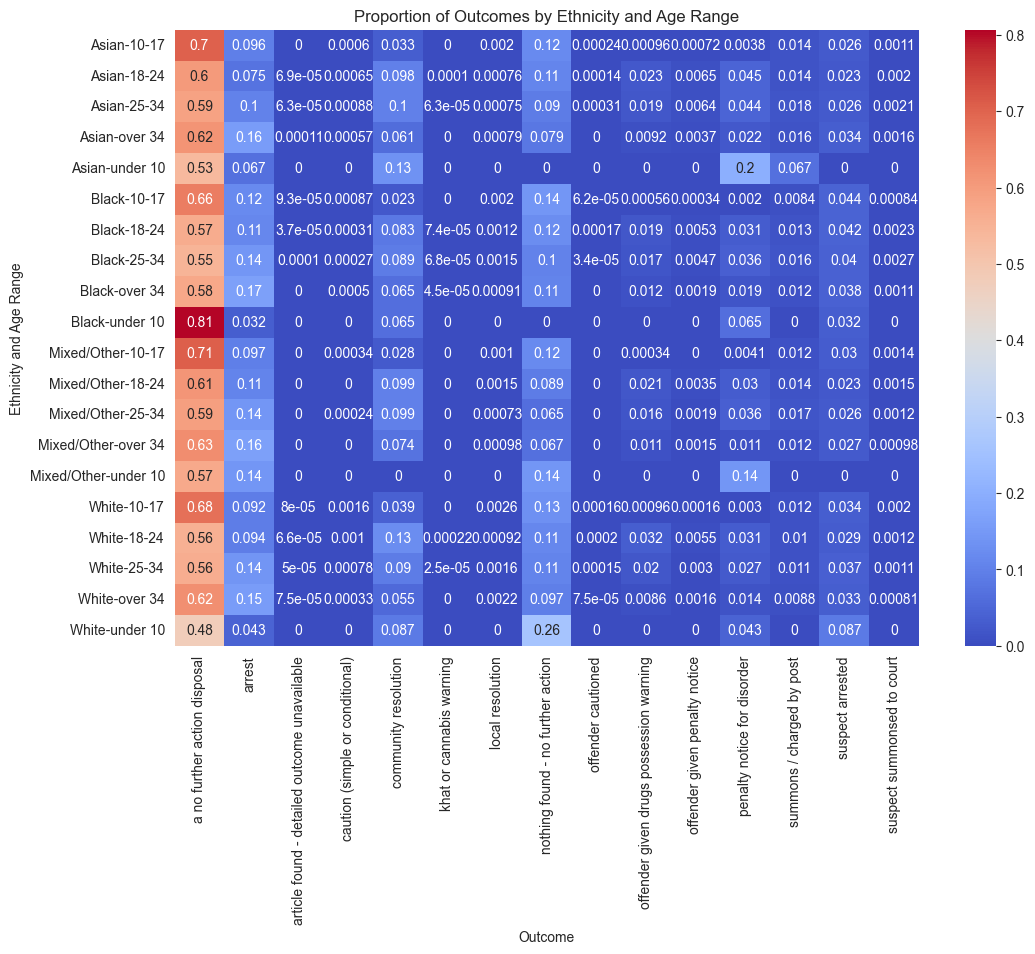

In [224]:
# Calculate proportions for ethnicity, age range, and outcome
ethnicity_age_outcome_ct = pd.crosstab([stop_and_search_df['grouped_ethnicity'], stop_and_search_df['age_range']], stop_and_search_df['outcome'], normalize='index')
print(ethnicity_age_outcome_ct)
chi2, p, dof, ex = chi2_contingency(ethnicity_age_outcome_ct)
print(f"Chi-squared Test: chi2 = {chi2}, p-value = {p}")

# Visualize the relationship
plt.figure(figsize=(12, 8))
sns.heatmap(ethnicity_age_outcome_ct, annot=True, cmap='coolwarm')
plt.title('Proportion of Outcomes by Ethnicity and Age Range')
plt.xlabel('Outcome')
plt.ylabel('Ethnicity and Age Range')
plt.xticks(rotation=90)
plt.show()


/var/folders/j3/c6lj_2051kdcm9d4lrwsyf0r0000gn/T/ipykernel_3641/2162342565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=stop_and_search_df, x='age_range', palette='viridis')


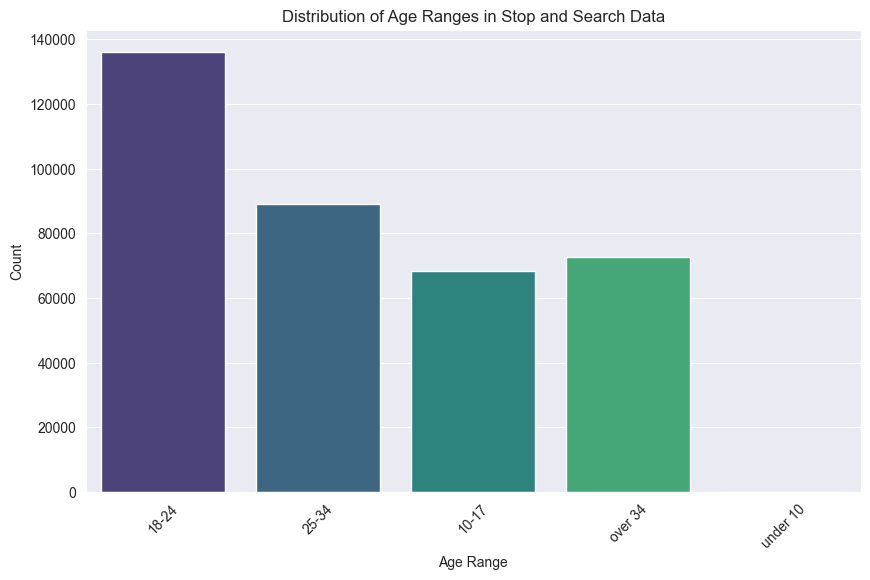

In [225]:
# Plot the distribution of age ranges
plt.figure(figsize=(10, 6))
sns.countplot(data=stop_and_search_df, x='age_range', palette='viridis')
plt.title('Distribution of Age Ranges in Stop and Search Data')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()